## Explore Discrimination in Credit-Scoring Models

### Using Logistic Regression to Build a Credit-Scoring Model

### Load library

In [1]:
library(tidyverse)
library(modelr)
library(plotROC)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Warning message:
“package ‘plotROC’ was built under R version 3.4.1”

options

In [2]:
options(repr.matrix.max.rows=10)
options(repr.matrix.max.colunms=20)
options(repr.plot.width=6)
options(repr.plot.height=8)

### Load data

create column name vector

In [3]:
col_names = c("CheckingAcct", "Duration", "CreditHist", "Purpose", "CreditAmount",
              "SavingAcct", "EmploymentTime", "InstallmentOverIncome", "Gender", "Guarantors",
              "ResidenceTime", "Property", "Age", "OtherInstallment", "Housing",
              "CreditsNum", "JobStatus", "GuarantorsNum", "Telephone", "Foreigner",
              "GoodRisk")

load data and convert character columns to categorical ones.

In [4]:
credit_raw = read_delim("data/german.data", 
                        delim=" ",
                        col_names=col_names) %>% 
    mutate(GoodRisk=GoodRisk==1)
# credit_raw

Parsed with column specification:
cols(
  .default = col_character(),
  Duration = col_integer(),
  CreditAmount = col_integer(),
  InstallmentOverIncome = col_integer(),
  ResidenceTime = col_integer(),
  Age = col_integer(),
  CreditsNum = col_integer(),
  GuarantorsNum = col_integer(),
  GoodRisk = col_integer()
)
See spec(...) for full column specifications.


### Exploring the Data
We may need to explore qualitative and quantative variables seperately

Create column name vectors for qualitative and quantative variables

In [5]:
col_qualitative = c("CheckingAcct", "CreditHist", "Purpose", "SavingAcct", 
                    "EmploymentTime", "Gender", "Guarantors","Property", 
                    "OtherInstallment", "Housing", "JobStatus", "Telephone", "Foreigner")
col_quantitative = c("Duration", "CreditAmount", "InstallmentOverIncome","ResidenceTime", 
                   "Age", "CreditsNum", "GuarantorsNum")

Select qualitative and quantative data

In [6]:
qualitative = credit_raw %>%
    select(one_of(col_qualitative), GoodRisk)
quantitative = credit_raw %>%
    select(one_of(col_quantitative), GoodRisk)
# qualitative
# quantative

**Let's look at qualitative variables first**

For each qualitative variable, we want to look at the GoodRisk rate distribution on each category of that variable.

Convert wide dataframe to tall format in order to plot all distributions side by side.

In [7]:
tall_qualitative = qualitative %>%
    gather("var", "value", -GoodRisk) %>%
    select(var, value, GoodRisk)
# tall_qualitative

Compute mean to get Good Risk rate

In [8]:
goodrate.qualitative = tall_qualitative %>%
    group_by(var, value) %>%
    summarize(GoodRiskRate=mean(GoodRisk),
              UserCount=n()) %>%
    ungroup()

Bar plot for good risk rate vs. category. 

The number shown above each bar is the count number of data entries in that category. We need this information, since the trend of good risk rate is not realiable when the data in each category are very few. 

In [9]:
options(repr.plot.width=10)
options(repr.plot.height=8)

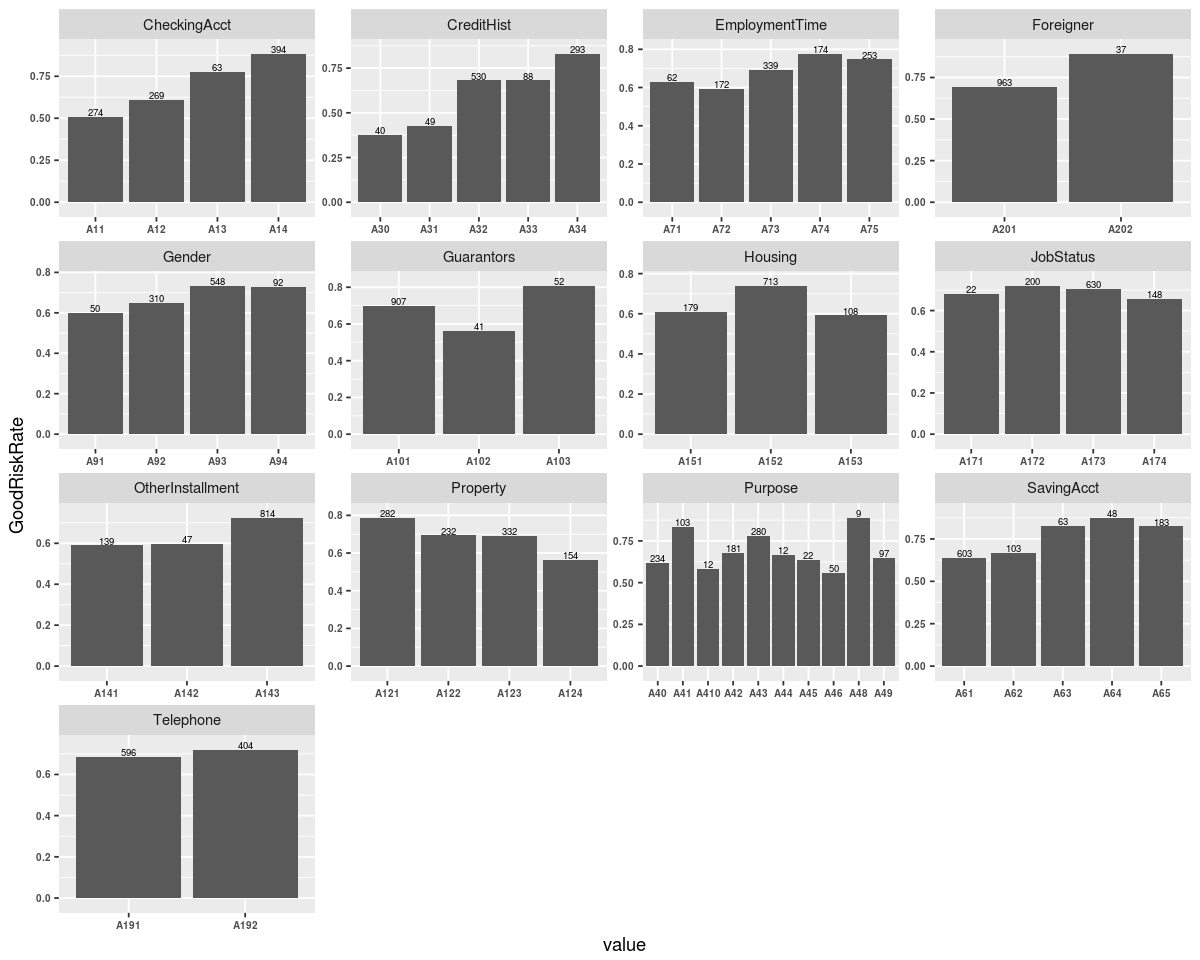

In [10]:
ggplot(goodrate.qualitative) +
    aes(x=value, y=GoodRiskRate) +
    geom_bar(stat="identity") +
    geom_text(mapping=aes(label=UserCount), 
                          vjust=-0.1, 
                          size=2) +
    scale_y_continuous(expand = c(0.1, 0)) +
    facet_wrap(~var, scales="free") +
    theme(legend.position="none",
          axis.text=element_text(face="bold",size=6)) 

It seems that **checking ans saving account status, credit history, employment time, job status, gender, housing, and property** are ordered factors to good risk rate. So we can change these categories to ordered factors. We also don't want to add biases to gender so the gender category is kept unchanged.

In [11]:
credit_factor_data = credit_raw %>%
    mutate(CheckingAcct=factor(CheckingAcct, ordered=TRUE, levels=c("A11","A12","A13","A14")),
           CreditHist=factor(CreditHist, ordered=TRUE, levels=c("A30","A31","A32","A33","A34")),
           SavingAcct=factor(SavingAcct, ordered=TRUE, levels=c("A61","A62","A63","A64","A65")),
           JobStatus=factor(JobStatus, ordered=TRUE, levels=c("A171","A172","A173","A174")),
           Housing=factor(Housing, ordered=TRUE, levels=c("A153", "A151", "A152")),
           Property=factor(Property, ordered=TRUE, levels=c("A124","A123","A122","A121")),
           EmploymentTime=factor(EmploymentTime, ordered=TRUE, levels=c("A71","A72","A73","A74","A75")),
           Purpose=as.factor(Purpose),
           Guarantors=as.factor(Guarantors),
           Property=as.factor(Property),
           OtherInstallment=as.factor(OtherInstallment),
           Telephone=as.factor(Telephone))

**Predictor candidates: CheckingAcct, SavingAcct, CreditHist, EmploymentTime, JobStatus, Housing, Property**

**Let's look at quantitative data.**

First check the summary.

In [12]:
summary(quantitative)

    Duration     CreditAmount   InstallmentOverIncome ResidenceTime  
 Min.   : 4.0   Min.   :  250   Min.   :1.000         Min.   :1.000  
 1st Qu.:12.0   1st Qu.: 1366   1st Qu.:2.000         1st Qu.:2.000  
 Median :18.0   Median : 2320   Median :3.000         Median :3.000  
 Mean   :20.9   Mean   : 3271   Mean   :2.973         Mean   :2.845  
 3rd Qu.:24.0   3rd Qu.: 3972   3rd Qu.:4.000         3rd Qu.:4.000  
 Max.   :72.0   Max.   :18424   Max.   :4.000         Max.   :4.000  
      Age          CreditsNum    GuarantorsNum    GoodRisk      
 Min.   :19.00   Min.   :1.000   Min.   :1.000   Mode :logical  
 1st Qu.:27.00   1st Qu.:1.000   1st Qu.:1.000   FALSE:300      
 Median :33.00   Median :1.000   Median :1.000   TRUE :700      
 Mean   :35.55   Mean   :1.407   Mean   :1.155   NA's :0        
 3rd Qu.:42.00   3rd Qu.:2.000   3rd Qu.:1.000                  
 Max.   :75.00   Max.   :4.000   Max.   :2.000                  

Convert wide data frame to tall data frame for plotting.

In [13]:
tall_quantitative = quantitative %>%
    gather("var", "value", -GoodRisk, factor_key=TRUE) %>%
    select(var, value, GoodRisk)
# tall_quantitative

Check unique values in each category.

In [14]:
tall_quantitative %>%
    group_by(var) %>%
    summarize(totalNum=n(),
              uniqueNum=n_distinct(value))

var,totalNum,uniqueNum
Duration,1000,33
CreditAmount,1000,921
InstallmentOverIncome,1000,4
ResidenceTime,1000,4
Age,1000,53
CreditsNum,1000,4
GuarantorsNum,1000,2


From above, we can see InstallmentOverIncome (Installment rate in percentage of disposable income), ResidenceTime, CreditsNum and GuarantorsNum can also be seen as categorical data. So we choose bar plot to show good risk rate of these categories. The remaining variables are plotted by boxplot or histogram.

In [15]:
goodrate.quantitative = tall_quantitative %>%
    filter(var %in% c("InstallmentOverIncome", "ResidenceTime", "CreditsNum", "GuarantorsNum")) %>%
    group_by(var, value) %>%
    summarize(GoodRiskRate=mean(GoodRisk),
              UserCount=n()) %>%
    ungroup()

In [16]:
options(repr.plot.width=8)
options(repr.plot.height=3)

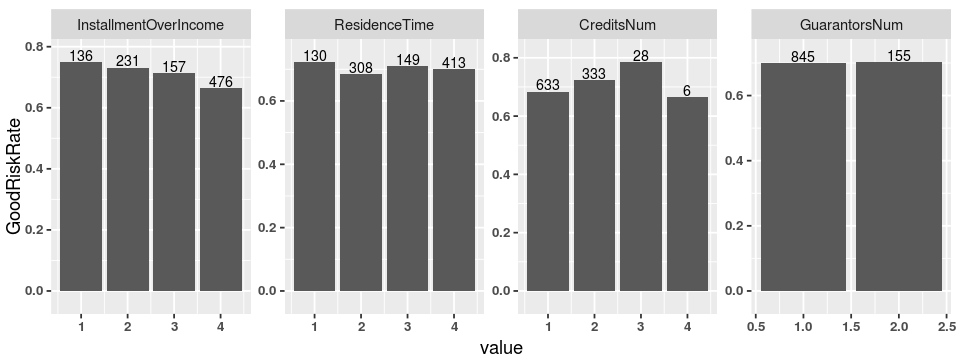

In [17]:
ggplot(goodrate.quantitative) +
    aes(x=value, y=GoodRiskRate) +
    geom_bar(stat="identity") +
    geom_text(mapping=aes(label=UserCount), 
                          vjust=-0.1, 
                          size=3) +
    scale_y_continuous(expand = c(0.1, 0)) +
    facet_wrap(~var, scales="free",ncol=4) +
    theme(legend.position="none",
          axis.text=element_text(face="bold",size=8)) 

It seems that good risk rate decreases while Installment rate in percentage of disposable income increases. And credits number also seems like a good predictor.

**Predictor candidates: InstallmentOverIncome, CreditsNum**

In [18]:
options(repr.plot.width=10)
options(repr.plot.height=5)

Plot histogram of Duration and Age and stack false good risk on true good risk to see the proportion.

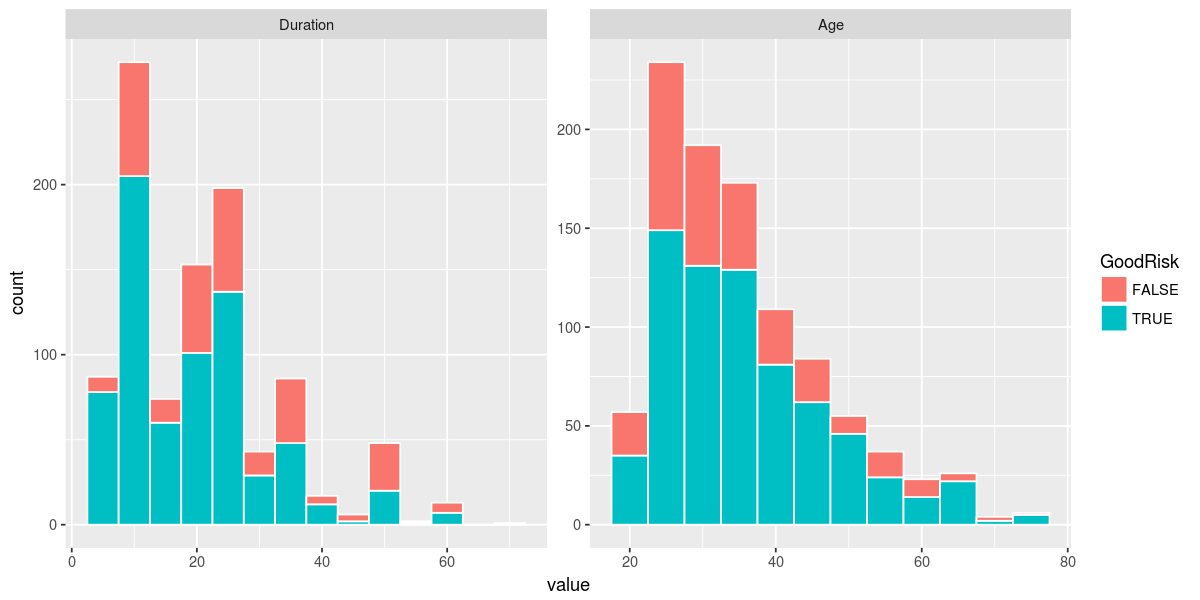

In [19]:
ggplot(tall_quantitative %>% filter(var %in% c("Age", "Duration"))) +
    aes(x=value, fill=GoodRisk) +
    geom_histogram(position="stack", binwidth=5, col="white") +
    facet_wrap(~var, scales="free")

Plot boxplot

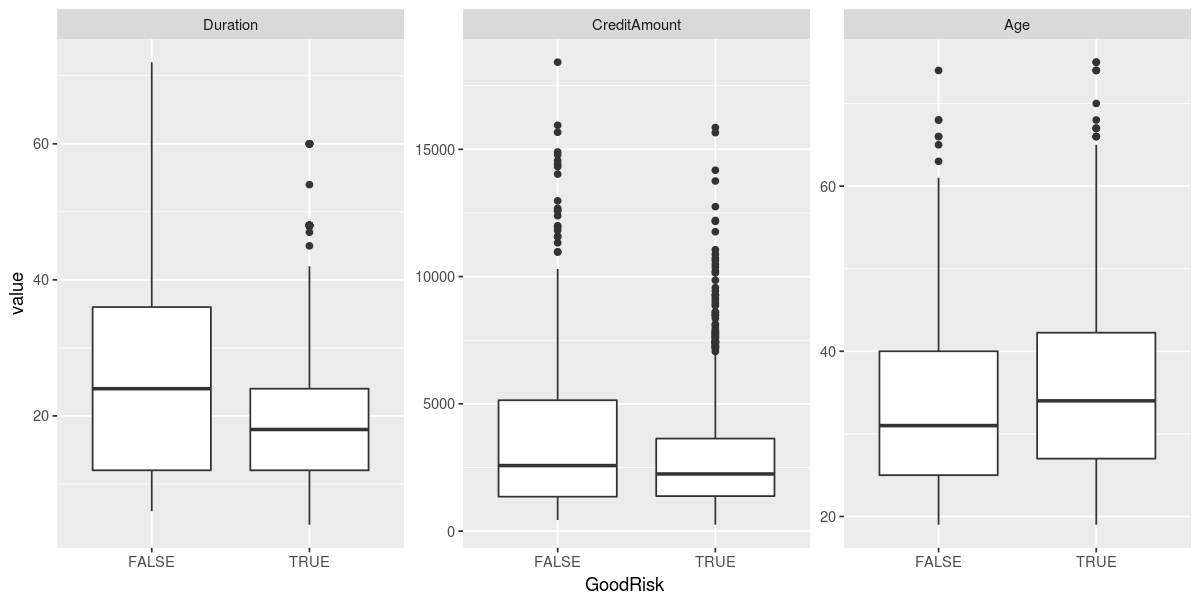

In [20]:
ggplot(tall_quantitative %>% filter(var %in% c("Age", "Duration", "CreditAmount"))) +
    aes(x=GoodRisk, y=value) +
    geom_boxplot() +
    facet_wrap(~var, scales="free")

It seems _Duration_ between 10 to 30 and _Age_ between 25 to 45 are good risk. And the median are also not close to each other between _TRUE_ and _FALSE_ categories for these two variables. _CreditAmount_ seems not to have very distinct distribution between True and False Good Risk.

**Predictor candidates: Duration**

In [21]:
options(repr.plot.width=5)
options(repr.plot.height=5)

For the remaining quantative variables, we are going to look at the correlation coefficient. And it's often useful to plot the heatmap of these coefficients.

Plot heatmap for quantitative variables


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



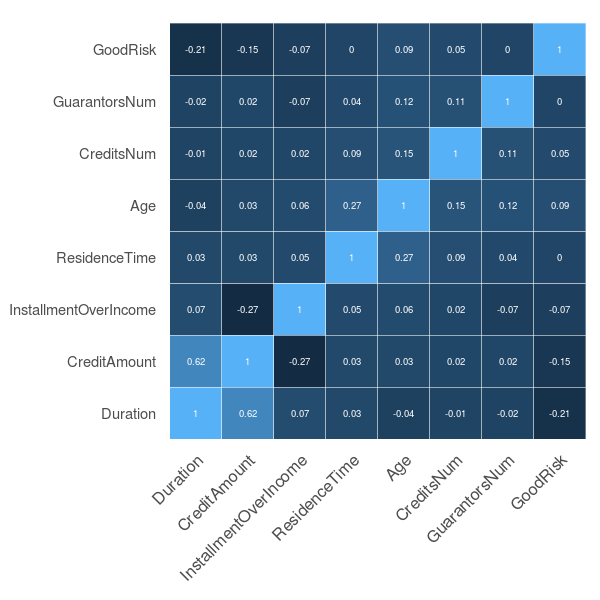

In [22]:
library(reshape2)
cormat <- round(cor(quantitative),2)
melted_cormat <- melt(cormat) 
ggplot(melted_cormat) +
    aes(Var2, Var1, fill = value) +
    geom_tile(color="white") +
    coord_equal() +
    geom_text(aes(Var2, Var1, label = value), color = "white", size = 2) +
    theme(axis.text.x = element_text(angle = 45, 
                                     size = 10, 
                                     hjust = 1),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          panel.background = element_blank(),
          axis.ticks = element_blank(),
          legend.position = "none")

_CreditAmount_ and _Duration_ have high correlation.

### Training Model

Split data to training and test data sets. 90% training and 10% test.

_Gender_ and _Foreigner_ features are removed from training and test data.

In [23]:
credit_isTest = credit_factor_data %>%
    mutate(isTest=runif(n())>0.9)
train = credit_isTest %>%
    filter(isTest==FALSE) %>%
    select(-one_of("isTest","Gender","Foreigner"))
test = credit_isTest %>%
    filter(isTest==TRUE) %>%
    select(-one_of("isTest","Gender","Foreigner"))
train %>% nrow()
test %>% nrow()

[1] 885

[1] 115

**Build logistic regressions models**

Build _full model_ using features including a linear combination of all variables except Gender and Foreigner

In [24]:
full_model = glm(GoodRisk ~ ., data=train, family=binomial())
summary(full_model)


Call:
glm(formula = GoodRisk ~ ., family = binomial(), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6143  -0.6932   0.3778   0.7036   2.2756  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)            2.115e+00  7.708e-01   2.744 0.006060 ** 
CheckingAcct.L         1.274e+00  1.855e-01   6.868 6.51e-12 ***
CheckingAcct.Q         3.936e-01  2.277e-01   1.729 0.083881 .  
CheckingAcct.C         1.742e-01  2.645e-01   0.659 0.510090    
Duration              -2.708e-02  9.849e-03  -2.749 0.005978 ** 
CreditHist.L           1.346e+00  3.348e-01   4.021 5.79e-05 ***
CreditHist.Q           2.294e-01  3.026e-01   0.758 0.448458    
CreditHist.C          -2.455e-01  3.576e-01  -0.687 0.492340    
CreditHist^4           2.449e-01  2.614e-01   0.937 0.348862    
PurposeA41             1.405e+00  3.889e-01   3.614 0.000302 ***
PurposeA410            1.114e+00  8.136e-01   1.369 0.170857    
PurposeA42           

Do a feature selection using _stepAIC_ function

In [25]:
MASS::stepAIC(full_model,trace=FALSE)


Call:  glm(formula = GoodRisk ~ CheckingAcct + Duration + CreditHist + 
    Purpose + CreditAmount + SavingAcct + EmploymentTime + InstallmentOverIncome + 
    Guarantors + OtherInstallment + Housing + Telephone, family = binomial(), 
    data = train)

Coefficients:
          (Intercept)         CheckingAcct.L         CheckingAcct.Q  
            1.8422630              1.2810958              0.3359045  
       CheckingAcct.C               Duration           CreditHist.L  
            0.1227144             -0.0288841              1.3185389  
         CreditHist.Q           CreditHist.C           CreditHist^4  
            0.0928390             -0.1876939              0.2786868  
           PurposeA41            PurposeA410             PurposeA42  
            1.3954918              1.1971176              0.6852787  
           PurposeA43             PurposeA44             PurposeA45  
            0.7346355              0.7744407              0.1055654  
           PurposeA46          

Use features selected by stepAIC to build a model.

In [26]:
modelByStepAIC = glm(GoodRisk ~ CheckingAcct + Duration + CreditHist + 
    Purpose + CreditAmount + SavingAcct + EmploymentTime + InstallmentOverIncome + 
    Guarantors + OtherInstallment + Housing, data=train, family=binomial())
summary(modelByStepAIC)


Call:
glm(formula = GoodRisk ~ CheckingAcct + Duration + CreditHist + 
    Purpose + CreditAmount + SavingAcct + EmploymentTime + InstallmentOverIncome + 
    Guarantors + OtherInstallment + Housing, family = binomial(), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6580  -0.7419   0.3882   0.7009   2.2473  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)            1.925e+00  4.617e-01   4.169 3.06e-05 ***
CheckingAcct.L         1.297e+00  1.831e-01   7.084 1.40e-12 ***
CheckingAcct.Q         3.432e-01  2.222e-01   1.545 0.122409    
CheckingAcct.C         1.284e-01  2.613e-01   0.492 0.623038    
Duration              -3.088e-02  9.467e-03  -3.262 0.001105 ** 
CreditHist.L           1.320e+00  3.236e-01   4.081 4.49e-05 ***
CreditHist.Q           8.686e-02  2.771e-01   0.313 0.753928    
CreditHist.C          -2.052e-01  3.441e-01  -0.596 0.550881    
CreditHist^4           2.666e-01  2.565e-01  

Consider interaction features _CreditAmount_, _CreditHist_ to build another model.

In [27]:
modelQuadratic = glm(GoodRisk ~ CheckingAcct + SavingAcct + Duration + OtherInstallment + CreditsNum + 
            EmploymentTime + InstallmentOverIncome + Guarantors + Housing + 
            Purpose + OtherInstallment + CreditAmount*CreditHist, 
            data=train, family=binomial())
summary(modelQuadratic)


Call:
glm(formula = GoodRisk ~ CheckingAcct + SavingAcct + Duration + 
    OtherInstallment + CreditsNum + EmploymentTime + InstallmentOverIncome + 
    Guarantors + Housing + Purpose + OtherInstallment + CreditAmount * 
    CreditHist, family = binomial(), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7681  -0.7212   0.3910   0.7020   2.1567  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                2.017e+00  5.653e-01   3.567 0.000361 ***
CheckingAcct.L             1.314e+00  1.859e-01   7.069 1.56e-12 ***
CheckingAcct.Q             3.596e-01  2.254e-01   1.596 0.110579    
CheckingAcct.C             1.295e-01  2.638e-01   0.491 0.623540    
SavingAcct.L               9.891e-01  2.811e-01   3.518 0.000435 ***
SavingAcct.Q              -2.833e-01  3.256e-01  -0.870 0.384338    
SavingAcct.C              -5.564e-01  4.623e-01  -1.203 0.228818    
SavingAcct^4              -4.856e-01  4.527e-0

### Evaluate Model Effectiveness

Add predictions to test data for each model.

In [28]:
test_full_model = test %>%
    add_predictions(full_model)
# test_full_model

In [29]:
test_modelByStepAIC = test %>%
    add_predictions(modelByStepAIC)
# test_modelByStepAIC

In [30]:
test_modelQuadratic = test %>%
    add_predictions(modelQuadratic)
# test_modelQuadratic

Bind data to plot

In [31]:
test_preds = bind_rows(Full=test_full_model,
                       StepAICFeatures=test_modelByStepAIC,
                       Quadratic=test_modelQuadratic,
                       .id="Model")
# test_preds

Plot ROC

In [32]:
options(repr.plot.width=8)
options(repr.plot.height=5)

Warning message in super():
“bytecode version mismatch; using eval”Warning message in verify_d(data$d):
“D not labeled 0/1, assuming FALSE = 0 and TRUE = 1!”

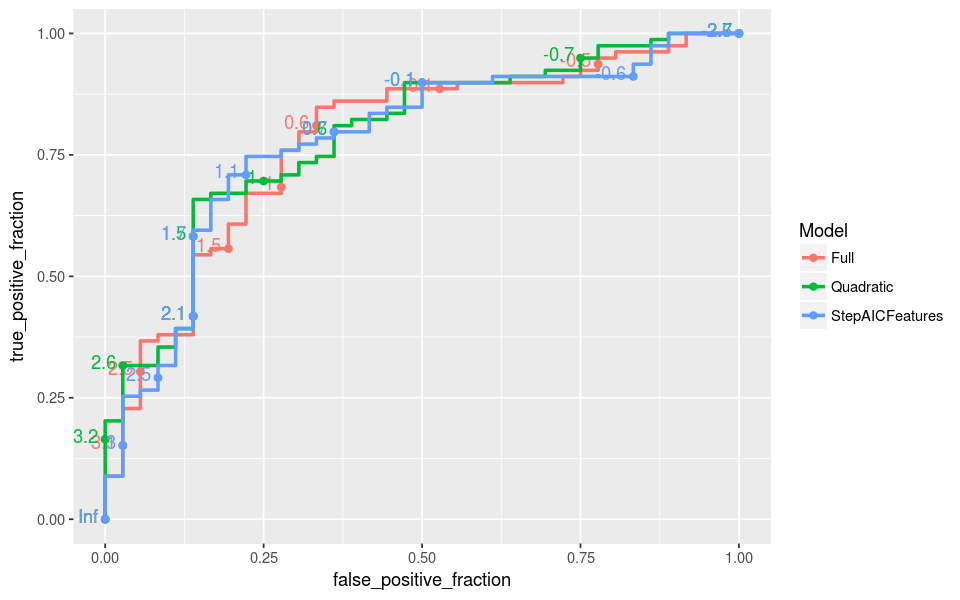

In [33]:
roc_plot = ggplot(test_preds) +
    aes(d=GoodRisk, m=pred, color=Model) +
    geom_roc()
roc_plot

Calculate AUR

In [34]:
calc_auc(roc_plot)

Warning message in verify_d(data$d):
“D not labeled 0/1, assuming FALSE = 0 and TRUE = 1!”

PANEL,group,AUC
1,1,0.7795359
1,2,0.7883263
1,3,0.7781294


It seems StepAicFeatures Model has the largest AUR, the second one is the model containing interaction features.

Compute **cost** of each model. 

- The **_cost_** is defined by data set provider, a false positive has a cost of 5, and a false negative has a cost of 1.

Let's create a function to compute cost for given threshold and dataframe
- input dataframe should include columns: _Model_, _GoodRisk_, _pred_

In [35]:
computeCost = function(threshold, data) {
    data %>%
        mutate(Decision=(pred - threshold) > 0) %>%
        filter(xor(GoodRisk, Decision)) %>% ## filter false cases
        select(Model, GoodRisk, Decision) %>%
        group_by(Model, GoodRisk, Decision) %>%
        summarize(Count=n()) %>%
        ungroup() %>%
        mutate(Cost=ifelse(Decision, 5*Count, Count), ## Decision True - Actual False: cost 5 
               Threshold=threshold) %>%
        select(Model, Threshold, Cost)
}

Use _plyr::ldply_ function to bind results for each threshold
- threshold is a sequence within range _min preds_ to _max preds_ by step _0.1_

In [36]:
maxPreds = round(max(test_preds["pred"]), 1)
minPreds = round(min(test_preds["pred"]), 1)
thresholds = seq(minPreds, maxPreds, 0.2)

costMatrix = plyr::ldply(thresholds, computeCost, test_preds) %>%
    group_by(Model, Threshold) %>%
    summarize(totalCost=sum(Cost)) %>%
    ungroup()
costMatrix

Model,Threshold,totalCost
Full,-2.7,180
Full,-2.5,175
Full,-2.3,175
Full,-2.1,170
Full,-1.9,166
⋮,⋮,⋮
StepAICFeatures,4.7,77
StepAICFeatures,4.9,78
StepAICFeatures,5.1,78
StepAICFeatures,5.3,78


Group by _Model_ and find the minimum cost for each model
- keep corresponding threshold

In [37]:
minCost = costMatrix %>% 
    group_by(Model) %>% 
    summarize(minCost=min(totalCost),
              threshold=Threshold[which.min(totalCost)]) %>% 
    ungroup()
minCost

Model,minCost,threshold
Full,62,1.7
Quadratic,53,1.3
StepAICFeatures,57,1.5


Create labels for minimum value

In [38]:
minCost = minCost %>%
    mutate(coordsLabel=paste("Model:", Model, "Min Cost:", as.character(minCost), "With Threshold:", as.character(threshold)))
minCost

Model,minCost,threshold,coordsLabel
Full,62,1.7,Model: Full Min Cost: 62 With Threshold: 1.7
Quadratic,53,1.3,Model: Quadratic Min Cost: 53 With Threshold: 1.3
StepAICFeatures,57,1.5,Model: StepAICFeatures Min Cost: 57 With Threshold: 1.5


Plot _**Cost vs. Threshold**_ Curve

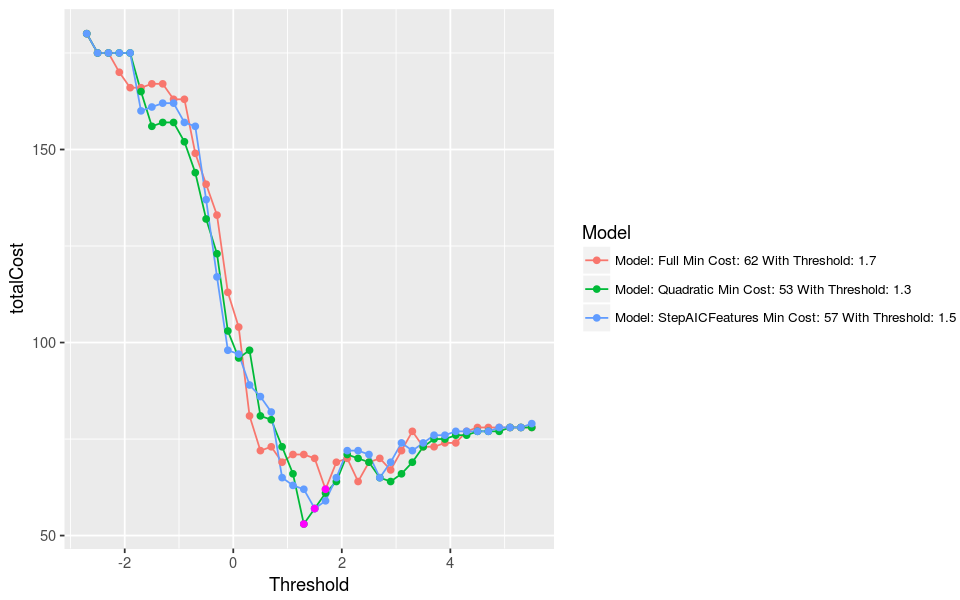

In [39]:
ggplot(costMatrix) +
    aes(x=Threshold, y=totalCost, color=Model) +
    geom_line() +
    geom_point() +
    geom_point(mapping=aes(x=threshold,y=minCost),data=minCost,color="#FF00FF") +
    scale_color_hue(name="Model",
                    breaks=c("Full","Quadratic","StepAICFeatures"),
                    labels=minCost[["coordsLabel"]]) +
    theme(legend.text=element_text(size=8))

Compute **Precision** and **Recall**
- For _Precision_, filter by Predicted Decision is True, and compute mean of Actual Good Risk
- For _Recall_, filter by Actual Good Risk is True, and compute mean of Predicted Decision

First get Decision column using threshold with minimum cost

In [40]:
model_decision = minCost %>%
    select(Model, threshold) %>%
    inner_join(test_preds) %>%
    mutate(Decision=(pred - threshold) > 0) %>%
    select(Model, GoodRisk, Decision)
# model_decision

Joining, by = "Model"


In [41]:
precision = model_decision %>%
    filter(Decision==TRUE) %>%
    group_by(Model) %>%
    summarize(Precision=mean(GoodRisk)) %>%
    ungroup()
precision

Model,Precision
Full,0.8936170
Quadratic,0.9107143
StepAICFeatures,0.9038462


In [42]:
recall = model_decision %>%
    filter(GoodRisk==TRUE) %>%
    group_by(Model) %>%
    summarize(Recall=mean(Decision)) %>%
    ungroup()
recall

Model,Recall
Full,0.5316456
Quadratic,0.6455696
StepAICFeatures,0.5949367


### Direct Discrimination

Protected Variables: _**Gender**_ and _**Foreigner**_

Since we don't use _**Gender**_ and _**Foreigner**_ as training feature, it seems that the model doesn't discriminate protected group directly.

In the following sections, we are going to choose _StepAICFeatures_ model as the final model.

Let's examinate it by first looking at the _Decision Rate_ of the final model in the protected groups.

Add the _Decision_ column using _StepAICFeatures_ model 

In [43]:
min.threshold = minCost %>%
    filter(Model=="StepAICFeatures") %>%
    select(threshold) %>%
    .[["threshold"]]

credit.feature.decision = credit_raw %>%
    add_predictions(modelByStepAIC) %>%
    mutate(Decision=(pred - min.threshold) > 0) %>%
    select(-one_of(c("pred"))) %>%
    mutate(Gender=ifelse(Gender=="A92", "Female", "Male"),
           Foreigner=ifelse(Foreigner=="A201", "Foreigner", "Native"))

Convert to tall dataframe for plots, and compute approval rate

In [44]:
approval.tall= credit.feature.decision %>%
    select(Gender, Foreigner, Decision) %>%
    gather("var", "value", -Decision) %>%
    group_by(var, value) %>%
    summarize(ApprovalRate=mean(Decision)) %>%
    ungroup()

In [45]:
approval.tall

var,value,ApprovalRate
Foreigner,Foreigner,0.4434060
Foreigner,Native,0.5675676
Gender,Female,0.4483871
Gender,Male,0.4478261


In [46]:
options(repr.plot.width=6)
options(repr.plot.height=3)

plot approval rate

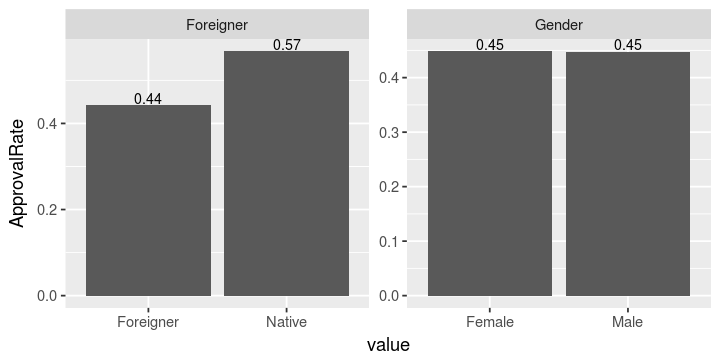

In [47]:
ggplot(approval.tall) +
    aes(x=value, y=ApprovalRate) +
    geom_bar(stat="identity") +
    geom_text(mapping=aes(label=round(ApprovalRate,2)), 
                          vjust=-0.1, 
                          size=3) +
#     ylim(0, 0.6) +
    facet_wrap(~var, scales="free")

Compute Disparate Impact between minority vs majority group 

In [48]:
Disparate.Impact.wide = approval.tall %>%
    select(value, ApprovalRate) %>%
    spread(value, ApprovalRate) %>%
    mutate(DI1=Female/Male,
           DI2=Foreigner/Native)

Disparate.Impact = bind_rows(Gender=select(Disparate.Impact.wide, Female, Male, DI1) %>%
             rename(MinGroup=Female, MajGroup=Male, DI=DI1),
          Nationality=select(Disparate.Impact.wide, Foreigner, Native, DI=DI2) %>%
             rename(MinGroup=Foreigner, MajGroup=Native),
          .id="ProtectedVars")
Disparate.Impact

ProtectedVars,MinGroup,MajGroup,DI
Gender,0.4483871,0.4478261,1.0012527
Nationality,0.4434060,0.5675676,0.7812392


From the value of Disparate Impact, we can see _Female_ group's approval rate is roughly the same to the _Male_ group's.

For foreigner worker, the approval rate is lower than the one of domestic worker. This number is close to 80% criteria. So it may show the existence of discrimination.

### Indirect Discrimination

While the protected characteristic is not directly used as training features, some features used in the model may still indirectly correlate with the protected characteristic. So in this section, we are going to examine the indirect discrimination.

We will look for three evidence:
- Correlations between the protected characteristic and the features used in the model
- Accuracy of the prediction using the protected characteristic to predict the final model's decisions
- Accuracy of the prediction using the protected characteristic to predict the final model's error

Let's look at the correlation first. The features used in the final model include: 
- **Qualitative**: _CheckingAcct, CreditHist, Purpose, SavingAcct, EmploymentTime, Guarantors, OtherInstallment and Housing_ 

- **Quantitative**: _Duration, CreditAmount, InstallmentOverIncome_

We look at the conditional distribution of the features used in the model given the protected characteristic. That is: 

\begin{equation*}P(X|Y_{y=A}) \quad \text{and} \quad P(X|Y_{y=B}) \end{equation*}

$X$ is one feature, like _EmploymentTime_, and $Y_{y=A}$ or $Y_{y=B}$ is one category of the protected characteristic, like _Female_ and _Male_.

If $X$ and $Y$ are independent, these two distributions should be same. But if these two distributions are totally different from each other, there must be some correlations between these two variables.    

For qualitative variables, plot histogram of the protected characteristic with respect to each feature.

In [49]:
qualitative.data = credit.feature.decision %>%
    select(CheckingAcct, CreditHist, Purpose, 
           SavingAcct, EmploymentTime, InstallmentOverIncome, 
           Guarantors, OtherInstallment, Housing, Gender, Foreigner)
quantitative.data = credit.feature.decision %>%
    select(Duration, CreditAmount, Gender, Foreigner)

# qualitative.data
# quantitative.data

In [50]:
options(repr.plot.width=10)
options(repr.plot.height=8)

**Correlation between Qualitative features with Gender**

Convert wide dataframe to tall dataframe and compute count and density for each category in each feature by _Gender_

In [51]:
category.count.gender = qualitative.data %>%
    select(-Foreigner) %>%
    gather("var", "value", -Gender) %>%
    group_by(var, value, Gender) %>%
    summarize(Count=n()) %>%
    ungroup()

var.count.gender = qualitative.data %>%
    select(-Foreigner) %>%
    gather("var", "value", -Gender) %>%
    group_by(var, Gender) %>%
    summarize(totalCount=n())

qualitative.stats.tall = category.count.gender %>%
    inner_join(var.count.gender) %>%
    mutate(Density=Count/totalCount)

Joining, by = c("var", "Gender")


Plot histogram

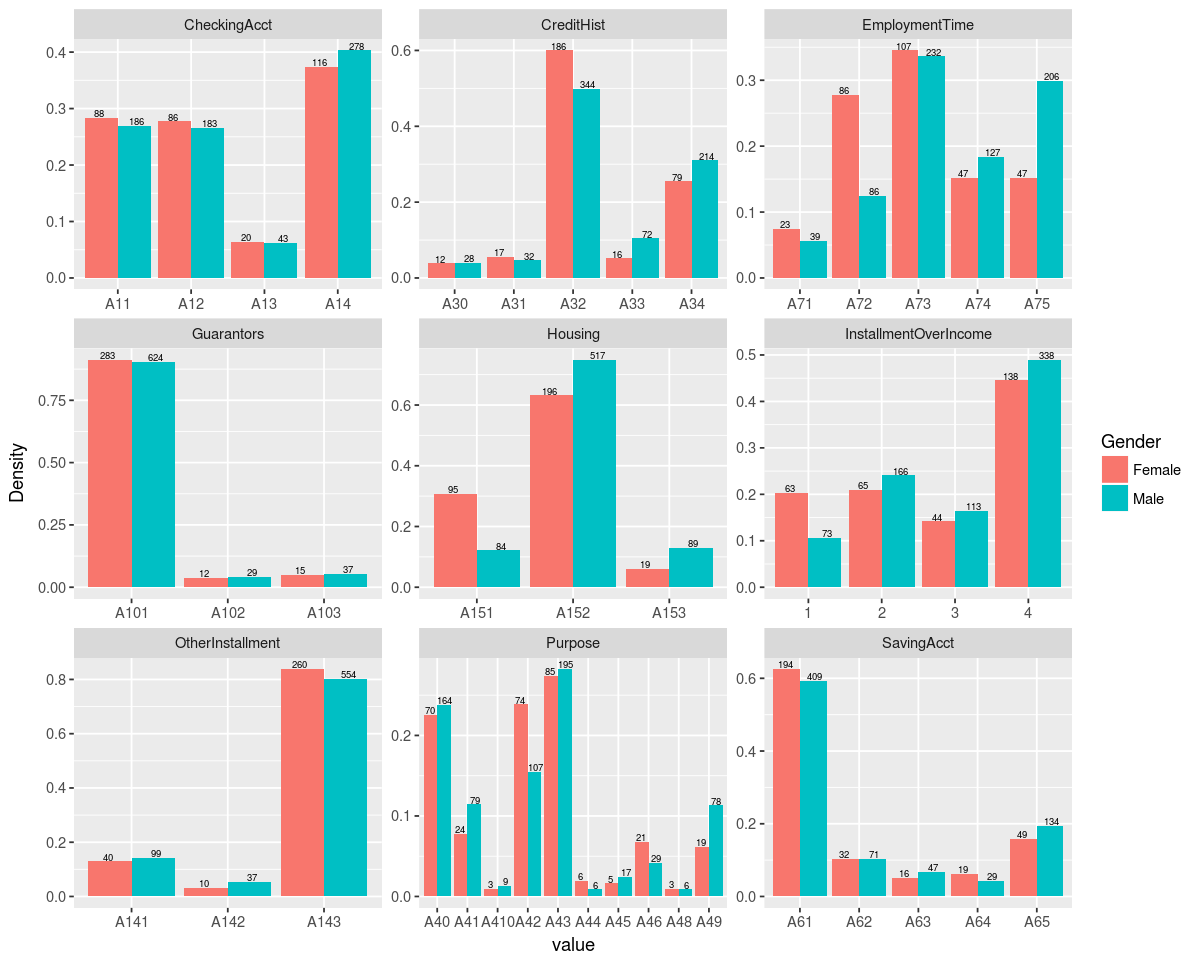

In [52]:
ggplot(qualitative.stats.tall) +
    aes(x=value, y=Density, fill=Gender) +
    geom_bar(stat="identity", position="dodge") +
    geom_text(aes(label=Count), 
              vjust=-0.1, 
              size=2,
              position = position_dodge(width = 1)) +
    facet_wrap(~var, scales="free")

From above, we can see that most distributions are similar to each other between _Female_ and _Male_ for each feature. But for feature _EmploymentTime_, the distribution given _Female_ are skewed left. However the distribution given _Male_ are skewed Right.

**Correlation between Qualitative features with Foreign Worker**

In [53]:
category.count.foreigner = qualitative.data %>%
    select(-Gender) %>%
    gather("var", "value", -Foreigner) %>%
    group_by(var, value, Foreigner) %>%
    summarize(Count=n()) %>%
    ungroup()

var.count.foreigner = qualitative.data %>%
    select(-Gender) %>%
    gather("var", "value", -Foreigner) %>%
    group_by(var, Foreigner) %>%
    summarize(totalCount=n())

qualitative.foreigner.stats.tall = category.count.foreigner %>%
    inner_join(var.count.foreigner) %>%
    mutate(Density=Count/totalCount)

Joining, by = c("var", "Foreigner")


Plot histogram

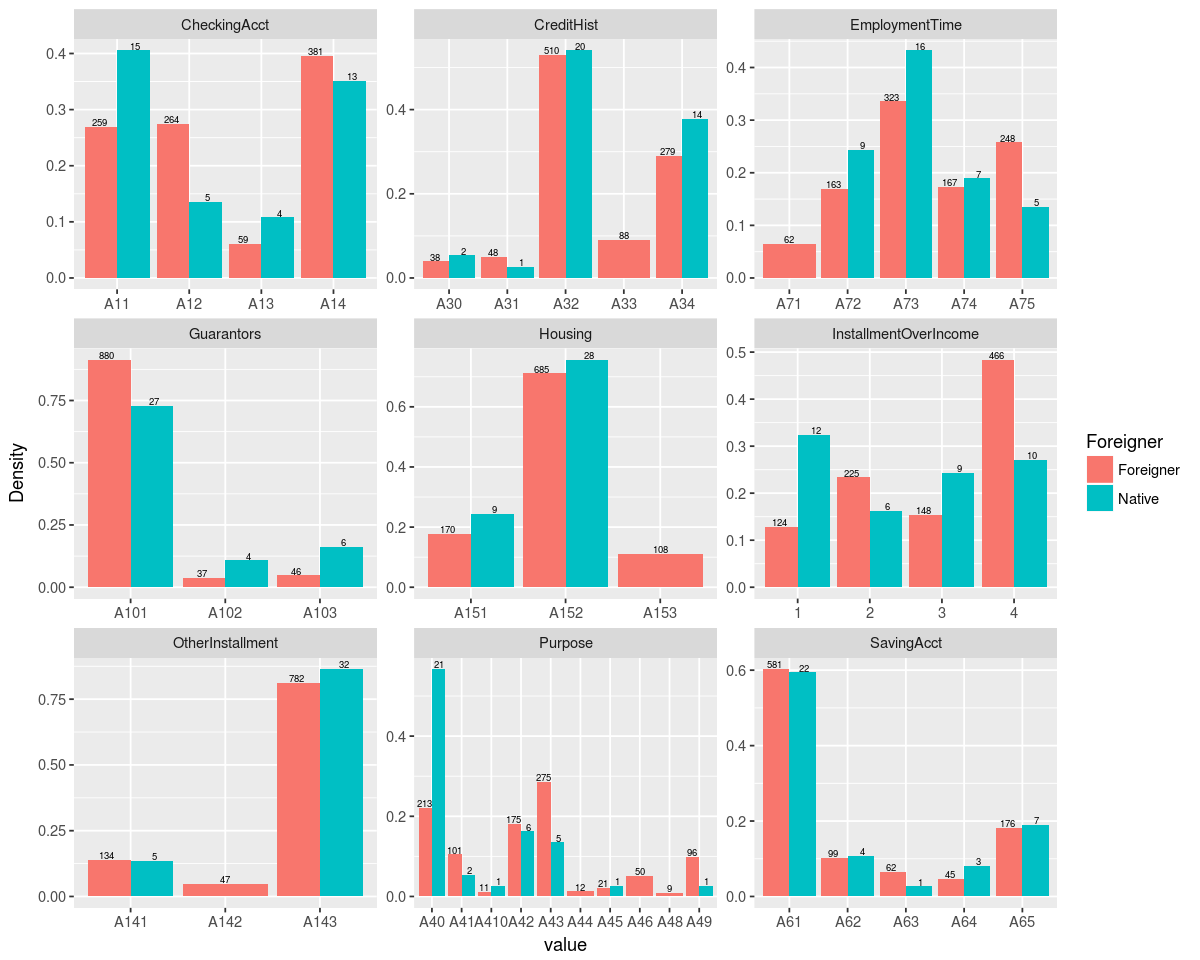

In [54]:
ggplot(qualitative.foreigner.stats.tall) +
    aes(x=value, y=Density, fill=Foreigner) +
    geom_bar(stat="identity", position="dodge") +
    geom_text(aes(label=Count), 
              vjust=-0.1, 
              size=2,
              position = position_dodge(width = 1)) +
    facet_wrap(~var, scales="free")

It seems that most distribution are similar to each other given _ForeignerWorker_ or _DomesticWorker_ for each feature. For some features, like _Housing_, _EmploymentTime_, there is one category which only contains _Foreigner Worker_

**Now let's explore correlation between quantitative features with gender and foreigner worker**

Correlation between _Duration_, _CreditAmount_ with _Gender_

Gather features to a tall dataframe and plot distributions.

In [55]:
quantitative.gender.tall = quantitative.data %>%
    select(-Foreigner) %>%
    gather("var", "value", -Gender)

In [56]:
options(repr.plot.width=10)
options(repr.plot.height=5)

Plot it

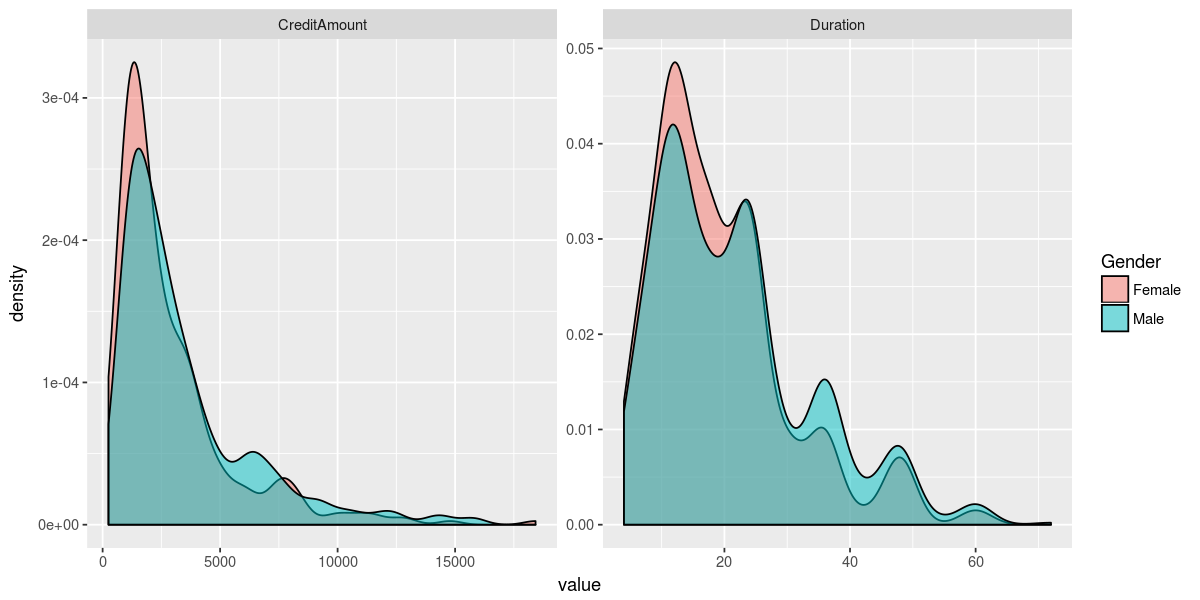

In [57]:
ggplot(quantitative.gender.tall) +
    aes(x=value, fill=Gender) +
    geom_density(alpha=0.5) +
    facet_wrap(~var, scales="free")

Do a same thing with _Foreigner_ characteristic

In [58]:
quantitative.foreigner.tall = quantitative.data %>%
    select(-Gender) %>%
    gather("var", "value", -Foreigner)

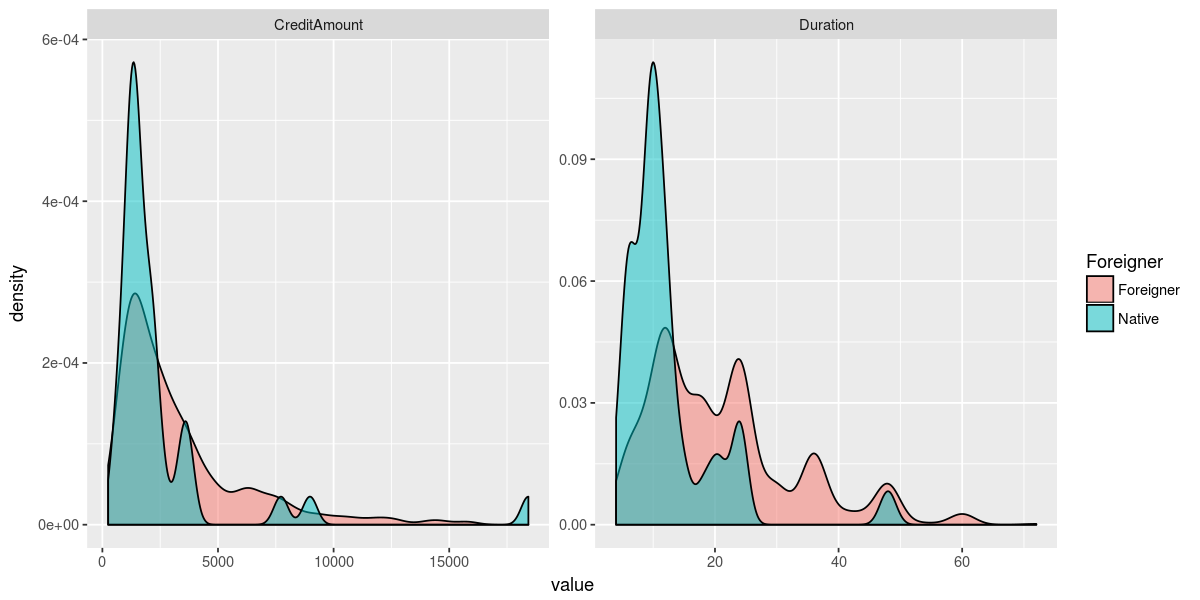

In [59]:
ggplot(quantitative.foreigner.tall) +
    aes(x=value, fill=Foreigner) +
    geom_density(alpha=0.5) +
    facet_wrap(~var, scales="free")

For _Gender_ characteristic, _Female_ and _Male_ have similar distributions with each other for _CreditAmount_ or _Duration_. However for _Foreigner_ characteristic, distributions of _CreditAmount_ and _Duration_ have some differences between _Foreign Worker_ and _Domestic Worker_ groups.

This may be the evidence of indirect discrimination. 

But We need to consider it carefully, so we are going to examine futher by predicting the model's decision using protected characteristics.

**Model Decision Prediction using Protected Characteristics**

Select _Gender_, _Foreigner_ and _Decision_, and split data to train and test.

In [60]:
decision.prediction.data = credit.feature.decision %>%
    select(Gender, Foreigner, GoodRisk, Decision) %>%
    mutate(Gender=as.factor(Gender),
           Foreigner=as.factor(Foreigner)) %>%
    mutate(isTest=runif(n())>0.9) %>%
    rename(DataGoodRisk=GoodRisk)
train.decision = decision.prediction.data %>%
    filter(isTest==FALSE) %>%
    select(-isTest)
test.decision = decision.prediction.data %>%
    filter(isTest==TRUE) %>%
    select(-isTest)
train.decision %>% nrow()
test.decision %>% nrow()

[1] 901

[1] 99

**Build logistic regression models with _Gender_, _Foreigner_ and Both features respectively**

In [61]:
model.predict.decision = glm(Decision ~ Gender + Foreigner, data=train.decision, family=binomial())
summary(model.predict.decision)


Call:
glm(formula = Decision ~ Gender + Foreigner, family = binomial(), 
    data = train.decision)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.276  -1.095  -1.082   1.262   1.276  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)  
(Intercept)     -0.22895    0.11954  -1.915   0.0555 .
GenderMale       0.03305    0.14434   0.229   0.8189  
ForeignerNative  0.42548    0.34279   1.241   0.2145  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1241.0  on 900  degrees of freedom
Residual deviance: 1239.4  on 898  degrees of freedom
AIC: 1245.4

Number of Fisher Scoring iterations: 3


In [62]:
model.predict.decision.gender = glm(Decision ~ Gender, data=train.decision, family=binomial())
summary(model.predict.decision.gender)


Call:
glm(formula = Decision ~ Gender, family = binomial(), data = train.decision)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.104  -1.104  -1.086   1.253   1.271  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept) -0.21841    0.11918  -1.833   0.0669 .
GenderMale   0.04263    0.14404   0.296   0.7672  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1241.0  on 900  degrees of freedom
Residual deviance: 1240.9  on 899  degrees of freedom
AIC: 1244.9

Number of Fisher Scoring iterations: 3


In [63]:
model.predict.decision.foreigner = glm(Decision ~ Foreigner, data=train.decision, family=binomial())
summary(model.predict.decision.foreigner)


Call:
glm(formula = Decision ~ Foreigner, family = binomial(), data = train.decision)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.274  -1.091  -1.091   1.266   1.266  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)   
(Intercept)     -0.20651    0.06836  -3.021  0.00252 **
ForeignerNative  0.42965    0.34230   1.255  0.20941   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1241.0  on 900  degrees of freedom
Residual deviance: 1239.4  on 899  degrees of freedom
AIC: 1243.4

Number of Fisher Scoring iterations: 3


Add predicition to test data for each model and bind them together.

In [64]:
test.decision.preds = bind_rows(Full=test.decision %>% add_predictions(model.predict.decision),
                                Gender=test.decision %>% add_predictions(model.predict.decision.gender),
                                ForeignWorker=test.decision %>% add_predictions(model.predict.decision.foreigner),
                                .id="Model")
test.decision.preds

Model,Gender,Foreigner,DataGoodRisk,Decision,pred
Full,Male,Foreigner,TRUE,TRUE,-0.1959030
Full,Male,Foreigner,TRUE,FALSE,-0.1959030
Full,Male,Foreigner,TRUE,TRUE,-0.1959030
Full,Male,Foreigner,TRUE,FALSE,-0.1959030
Full,Female,Foreigner,TRUE,TRUE,-0.2289492
⋮,⋮,⋮,⋮,⋮,⋮
ForeignWorker,Male,Foreigner,FALSE,FALSE,-0.2065112
ForeignWorker,Male,Foreigner,TRUE,TRUE,-0.2065112
ForeignWorker,Female,Foreigner,TRUE,FALSE,-0.2065112
ForeignWorker,Male,Foreigner,TRUE,FALSE,-0.2065112


Warning message in verify_d(data$d):
“D not labeled 0/1, assuming FALSE = 0 and TRUE = 1!”

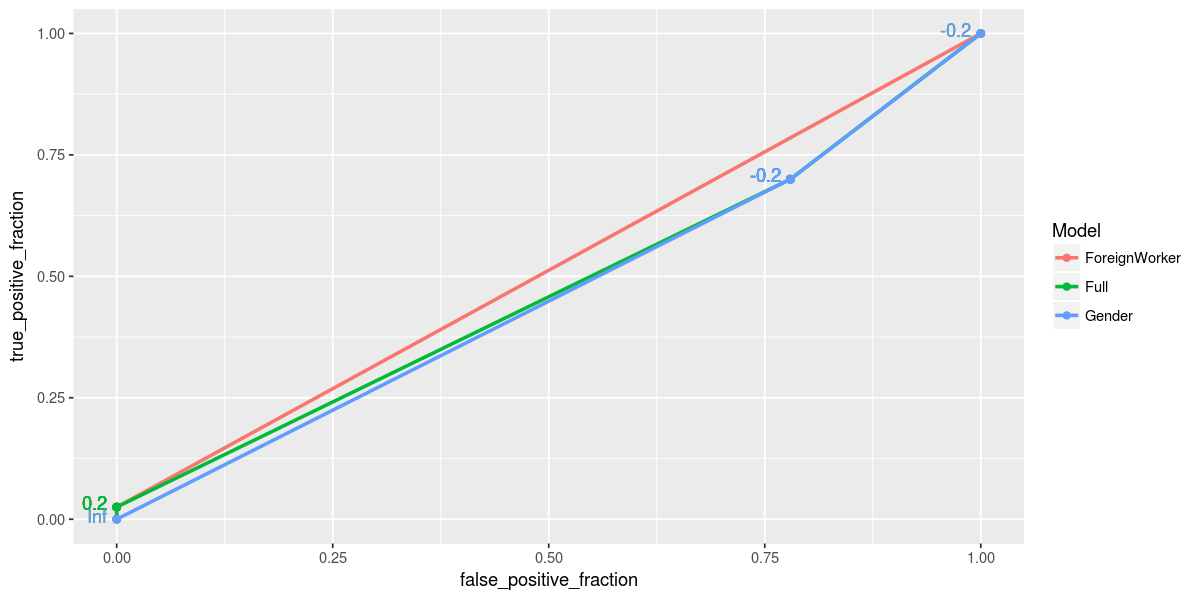

In [65]:
roc_plot = ggplot(test.decision.preds) +
    aes(d=Decision, m=pred, color=Model) +
    geom_roc()
roc_plot

Compute cost for each threshold

In [66]:
maxPreds = round(max(test.decision.preds["pred"]), 1)
minPreds = round(min(test.decision.preds["pred"]), 1)
thresholds = seq(minPreds, maxPreds, 0.01)

costMatrix = plyr::ldply(thresholds, computeCost, test.decision.preds %>% rename(GoodRisk=Decision)) %>%
    group_by(Model, Threshold) %>%
    summarize(totalCost=sum(Cost)) %>%
    ungroup()
costMatrix

Model,Threshold,totalCost
ForeignWorker,-0.20,39
ForeignWorker,-0.19,39
ForeignWorker,-0.18,39
ForeignWorker,-0.17,39
ForeignWorker,-0.16,39
⋮,⋮,⋮
Gender,0.16,40
Gender,0.17,40
Gender,0.18,40
Gender,0.19,40


Select first corresponding optimal threshold with minimum cost

In [67]:
minCost = costMatrix %>% 
    group_by(Model) %>% 
    summarize(minCost=min(totalCost),
              threshold=Threshold[which.min(totalCost)]) %>% 
    ungroup()

min.threshold.decision.foreigner = minCost %>% 
    filter(Model=="ForeignWorker") %>%
    select(threshold) %>%
    .[["threshold"]]

minCost

Model,minCost,threshold
ForeignWorker,39,-0.20
Full,39,-0.19
Gender,40,-0.17


Use optimal threshold to make decision prediciton

In [68]:
model_decision = minCost %>%
    select(Model, threshold) %>%
    inner_join(test.decision.preds) %>%
    mutate(PredictedDecision=(pred - threshold) > 0) %>%
    select(Model, Decision, PredictedDecision)

Joining, by = "Model"


Compute prediction accuracy of these three models

In [69]:
model_decision %>%
    mutate(CorrectPred=Decision==PredictedDecision) %>%
    group_by(Model) %>%
    summarize(correctRate=mean(CorrectPred),
              correctCount=sum(CorrectPred))

Model,correctRate,correctCount
ForeignWorker,0.6060606,60
Full,0.6060606,60
Gender,0.5959596,59


Prediciton accuracy for all the models are about 60%.

We can compare it with a random prediciton to see if the protected characteristics do a better prediction.

Compute the decision rate in training data and use that rate to randomly predict decision in test data.

In [70]:
decision.rate = mean(train.decision[["Decision"]])

test.random.preds = test.decision %>%
    mutate(isGood=runif(n()) < decision.rate)

Compute prediction accuracy of random predictor

In [71]:
mean(test.random.preds %>%
    mutate(CorrectPred=Decision==isGood) %>%
    .[["CorrectPred"]])

[1] 0.4949495

From above, we see that using protected characteristics indeed does a better prediction!

This may be evidence of **Indirect Discrimination**.

We also want to see if using protected characteristics can better predict the final model's error than a random predictor

**Model Error Prediction using Protected Characteristics**

Use same train-test partition but predict decision error

In [72]:
train.error = train.decision %>%
    mutate(isError=DataGoodRisk!=Decision) %>%
    select(Gender, Foreigner, isError)
test.error = test.decision %>%
    mutate(isError=DataGoodRisk!=Decision) %>%
    select(Gender, Foreigner, isError)
# train.error
# test.error

**Build logistic regression models to predict error**

Use _Gender_ and _Foreigner_

In [73]:
model.predict.error = glm(isError ~ Gender + Foreigner, data=train.error, family=binomial())
summary(model.predict.error)


Call:
glm(formula = isError ~ Gender + Foreigner, family = binomial(), 
    data = train.error)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0107  -0.9026  -0.8152   1.4798   1.5895  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.9310     0.1317  -7.069 1.56e-12 ***
GenderMale        0.2435     0.1568   1.553    0.120    
ForeignerNative   0.2817     0.3504   0.804    0.421    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1130.6  on 900  degrees of freedom
Residual deviance: 1127.4  on 898  degrees of freedom
AIC: 1133.4

Number of Fisher Scoring iterations: 4


Use _Gender_ feature

In [74]:
model.predict.error.gender = glm(isError ~ Gender, data=train.error, family=binomial())
summary(model.predict.error.gender)


Call:
glm(formula = isError ~ Gender, family = binomial(), data = train.error)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9077  -0.9077  -0.8178   1.4736   1.5862  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.9237     0.1313  -7.033 2.02e-12 ***
GenderMale    0.2499     0.1565   1.597     0.11    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1130.6  on 900  degrees of freedom
Residual deviance: 1128.1  on 899  degrees of freedom
AIC: 1132.1

Number of Fisher Scoring iterations: 4


Use _Foreigner_ feature

In [75]:
model.predict.error.foreigner = glm(isError ~ Foreigner, data=train.error, family=binomial())
summary(model.predict.error.foreigner)


Call:
glm(formula = isError ~ Foreigner, family = binomial(), data = train.error)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9925  -0.8748  -0.8748   1.5139   1.5139  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -0.76335    0.07302 -10.455   <2e-16 ***
ForeignerNative  0.31137    0.34959   0.891    0.373    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1130.6  on 900  degrees of freedom
Residual deviance: 1129.9  on 899  degrees of freedom
AIC: 1133.9

Number of Fisher Scoring iterations: 4


Bind results with prediction.

In [76]:
test.error.preds = bind_rows(Full=test.error %>% add_predictions(model.predict.error),
                                Gender=test.error %>% add_predictions(model.predict.error.gender),
                                ForeignWorker=test.error %>% add_predictions(model.predict.error.foreigner),
                                .id="Model")
# test.error.preds

Compute thresholds for each model based on cost function

In [77]:
maxPreds = round(max(test.error.preds["pred"]), 2)
minPreds = round(min(test.error.preds["pred"]), 2)
thresholds = seq(minPreds, maxPreds, 0.01)

costMatrix = plyr::ldply(thresholds, computeCost, test.error.preds %>% rename(GoodRisk=isError)) %>%
    group_by(Model, Threshold) %>%
    summarize(totalCost=sum(Cost)) %>%
    ungroup()
# costMatrix

Minimum cost with corresponding threshold

In [78]:
minCost = costMatrix %>% 
    group_by(Model) %>% 
    summarize(minCost=min(totalCost),
              threshold=Threshold[which.min(totalCost)]) %>% 
    ungroup()
minCost

Model,minCost,threshold
ForeignWorker,33,-0.45
Full,38,-0.68
Gender,33,-0.67


Use optimal threshold to make prediciton and compute accuracy

In [79]:
model_error = minCost %>%
    select(Model, threshold) %>%
    inner_join(test.error.preds) %>%
    mutate(PredictedError=(pred - threshold) > 0) %>%
    select(Model, isError, PredictedError)


model_error %>%
    mutate(CorrectPred=isError==PredictedError) %>%
    group_by(Model) %>%
    summarize(correctRate=mean(CorrectPred),
              correctCount=sum(CorrectPred))

Joining, by = "Model"


Model,correctRate,correctCount
ForeignWorker,0.6666667,66
Full,0.6565657,65
Gender,0.6666667,66


We can see all models has more than 60% accuracy to predict error.

We can also compare it with a random predictor.

Compute error rate in the training data

In [80]:
error.rate = mean(train.error[["isError"]])

Use this error rate to randomly predict errors in test data

In [81]:
test.random.error.preds = test.error %>%
    mutate(rndPredError=runif(n()) < error.rate)

Compute the accuracy of this random predictor

In [82]:
mean(test.random.error.preds %>%
    mutate(CorrectPred=isError==rndPredError) %>%
    .[["CorrectPred"]])

[1] 0.5252525

We can see that all the models using protected characteristics can get better predictions of the final model's error than a random predictor does.

From all the three methods, we may conclude that the final model has **indirect discrimination** to _Gender_ and _Foreigner Worker_.

Whether changing the cost weights can result in a more or less discriminatory model depends on which evaluation we used.

- For direct discrimination:
    1. if we consider whether the protected features are used, then changing the cost weights cannot impact our conclusion; 
    2. if we consider disparate impact, then changing the cost weights can impact our conclusion. Because the cost function determines the threshold, and different threshold will result in different classification boundaries for the test data, which will occasionally more or less change the model's decision rate for the protected group.


- For indiret discrimination:
    1. if we consider correlations between used features and the protected characteristics, chagning the cost weights cannot impact the conclusion;
    2. if we consider the ability of predicting decisions or errors of the model under investigation using protected characteristics, then changing the cost weights can result in a more or less discriminatiory model.

### Limitations

1.The ground truth may not be accurate. 
- In this assignment, we used _GoodRisk_ as labels to train a decision classifier. Where is the _GoodRisk_ from? Human judgements? If the judgements include some kinds of human biases, then the trained model may more or less capture those biases. 
- And a biased ground truth also cannot accurately judge errors of the model. Since one of our evaluation methods is based on errors of the main model, if the error is caused by a biased ground truth, then the error itself may not be the error of the model.


2.Even the ground truth is accurate, the data that we used may not be enough to evaluate the discrimination. One of most important limitation is that the data don't have timestamp. Our discrimination conclusion may result from the short-time limitation of the data. Which means at current time point, the model may be biased, but if we collect more data in the future, the performance of the model may become less biased than before.


3.When we evalute discrimination, we hope we can get some insights from the data. And we analyze distributions of some variables that we care about. Then we hope the distribution that we got reflects the true probabilities of those variables. One problem I guess is that once we collected data, the data itself is static and is a snapshot of history. If the data itself is biasedly correlated with some protected characteristics due to the input interface of data collection (For example, the _EmploymentTime_ variable never has unemployed domestic workers). Then we probably get a biased conclusion.

4.Another problem is that the evaluation methods we used may not be able to distinguish the characteristics between the data and the model, which means discrimination may come from data rather than the model. Also those methods may not be able to differentiate the discrimination between the general model and the model we trained with some specific weights. For example, when we say the model has discrimination, what do we mean? The logistic regression is biased or the logistic regression model we trained is biased? If we are looking at the latter one, then the methods used to evaluate indirect discrimination may have some problems. Because we were using an another model to judge the main model. What if the biases are coming from the judgement model?

To investigate the second limitation, we are going to make an extreme example in this section.

As we have already seen that the main model has discrimination with _Foreigner Worker_ group. We want to investigate the performance of the model in the future to see if the model is still biased. 

We assume that:
- in the first upcoming period, all the applicants are foreigners who have the _**"being accepted quality"**_. 
- in the second upcoming period, all the applicants are domestic worker who have the _**"being accepted quality"**_.
- our evaluations are conducted at three time period: 1. just before first upcoming period, 2. the end of first upcoming period, 3. the end of second upcoming period.
- to get these evaluation data, we sample the original data. Since the main model doesn't use _Foreigner_ feature, we can assume these sampled applicants are just the applicants with good quality!

Prepare evaluation dataset

In [83]:
modelByStepAIC.Decision = credit_factor_data %>%
    add_predictions(modelByStepAIC) %>%
    mutate(Decision=(pred - min.threshold) > 0) %>%
    select(-one_of(c("pred"))) %>%
    mutate(Gender=ifelse(Gender=="A92", "Female", "Male"),
           Foreigner=ifelse(Foreigner=="A201", "Foreigner", "Native"))

Filter all accepted history applicants: _foreigner_ and _native_.

In [84]:
foreigner.accepted = modelByStepAIC.Decision %>%
    filter(Foreigner=="Foreigner" & Decision==TRUE)
native.accepted = modelByStepAIC.Decision %>%
    filter(Foreigner=="Native" & Decision==TRUE)

Sample 1000 of each group

In [85]:
first.period = sample_n(foreigner.accepted, 1000, replace = TRUE)
second.period = sample_n(native.accepted, 1000, replace = TRUE)

Bind these samples in accumulated time periods

In [86]:
first.eval.dataset = modelByStepAIC.Decision %>%
    mutate(Period="First")

second.eval.dataset = bind_rows(modelByStepAIC.Decision,
          first.period) %>%
    mutate(Period="Second")

third.eval.dataset = bind_rows(modelByStepAIC.Decision,
          first.period,
          second.period) %>%
    mutate(Period="Third")

In [87]:
eval.dataset = bind_rows(first.eval.dataset,
          second.eval.dataset,
          third.eval.dataset) %>%
    select(Foreigner, Decision, Period)

Compute approval rate for each group

In [88]:
eval.approvalRate = eval.dataset %>%
    group_by(Period, Foreigner) %>%
    summarize(ApprovalRate = mean(Decision))

Plot it

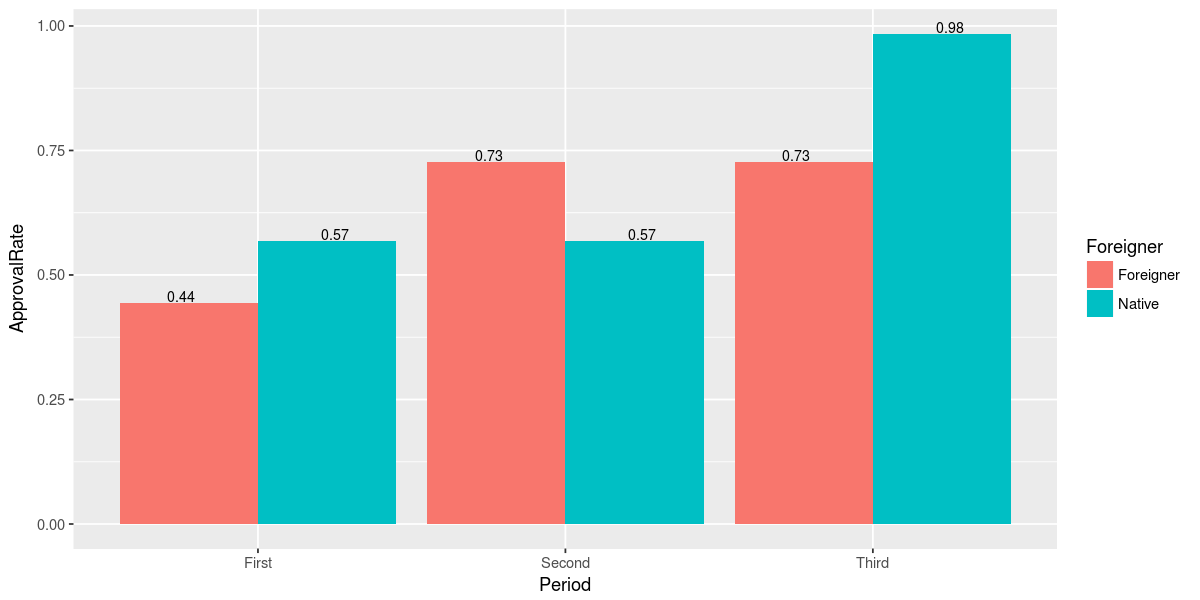

In [89]:
ggplot(eval.approvalRate) +
    aes(x=Period, y=ApprovalRate, fill=Foreigner) +
    geom_bar(stat="identity", position="dodge") +
    geom_text(mapping=aes(label=round(ApprovalRate,2)), 
                          vjust=-0.1, 
                          size=3,
              position = position_dodge(width = 1)) 

From above, we can see an evoluation history of discrimination! In the first period, the model has biases to foreign worker, but in the second period, it totaly changed its judgement and favored foreigner!

We can also do an experiment to re-train the model using these temporally biased data. Then we may see an evoluation history of machine learning model!

To investigate third and fourth limitation, we are going to do an another experiment.

It's not easy to discern the characteristics of the data from the trained model, since we used the same original dataset for our previous evaluation.

In this section, we are going to do an uniformly random sampling from the distinct values of each feature used in the main model. For quantitative feature, we uniformly sample values ranging from minimum value to maximum value of that feature.

In [90]:
sampleCheckingAcct = sample_n(modelByStepAIC.Decision %>% 
                              select(CheckingAcct) %>% 
                              distinct(), 
                              1000, 
                              replace = TRUE)

sampleCreditHist = sample_n(modelByStepAIC.Decision %>% 
                              select(CreditHist) %>% 
                              distinct(), 
                              1000, 
                              replace = TRUE)

samplePurpose = sample_n(modelByStepAIC.Decision %>% 
                              select(Purpose) %>% 
                              distinct(), 
                              1000, 
                              replace = TRUE)

sampleSavingAcct = sample_n(modelByStepAIC.Decision %>% 
                              select(SavingAcct) %>% 
                              distinct(), 
                              1000, 
                              replace = TRUE)

sampleEmploymentTime = sample_n(modelByStepAIC.Decision %>% 
                              select(EmploymentTime) %>% 
                              distinct(), 
                              1000, 
                              replace = TRUE)

sampleInstallmentOverIncome = sample_n(modelByStepAIC.Decision %>% 
                              select(InstallmentOverIncome) %>% 
                              distinct(), 
                              1000, 
                              replace = TRUE)

sampleGuarantors = sample_n(modelByStepAIC.Decision %>% 
                              select(Guarantors) %>% 
                              distinct(), 
                              1000, 
                              replace = TRUE)

sampleOtherInstallment = sample_n(modelByStepAIC.Decision %>% 
                              select(OtherInstallment) %>% 
                              distinct(), 
                              1000, 
                              replace = TRUE)

sampleHousing = sample_n(modelByStepAIC.Decision %>% 
                              select(Housing) %>% 
                              distinct(), 
                              1000, 
                              replace = TRUE)

sampleDuration = sample_n(data.frame(Duration = seq(min(modelByStepAIC.Decision %>% select(Duration)), 
                                                      max(modelByStepAIC.Decision %>% select(Duration)), 
                                                      1)), 
                              1000, 
                              replace = TRUE)

sampleCreditAmount = sample_n(data.frame(CreditAmount = seq(250, 20000, 1)), 
                              1000, 
                              replace = TRUE)

sampleForeigner = sample_n(modelByStepAIC.Decision %>% 
                              select(Foreigner) %>% 
                              distinct(), 
                              1000, 
                              replace = TRUE)

Bind sample columns

In [91]:
uniform.samples = bind_cols(sampleCheckingAcct,
          sampleCreditHist,
          samplePurpose,
          sampleSavingAcct,
          sampleEmploymentTime,
          sampleInstallmentOverIncome,
          sampleGuarantors,
          sampleOtherInstallment,
          sampleHousing,
          sampleDuration,
          sampleCreditAmount,
          sampleForeigner)

Feed these samples into the final model and compute decision

In [92]:
unif.samples.decision = uniform.samples %>%
    add_predictions(modelByStepAIC) %>%
    mutate(Decision=(pred - min.threshold) > 0) %>%
    select(-one_of(c("pred")))

Compute approval rate for foreign worker group

In [93]:
eval.unif.samples.approvalRate = unif.samples.decision %>%
    group_by(Foreigner) %>%
    summarize(ApprovalRate = mean(Decision))

eval.unif.samples.approvalRate

Foreigner,ApprovalRate
Foreigner,0.2191235
Native,0.2188755


From above, we can see that the foreign worker group even has a higher approval rate than native worker!

Feed the same samples into the judger model which is the model used to predict the final model's decisions.

In [94]:
unif.samples.judger.decision = uniform.samples %>%
    add_predictions(model.predict.decision.foreigner) %>%
    mutate(Decision=(pred - min.threshold.decision.foreigner) > 0) %>%
    select(-one_of(c("pred")))

In [95]:
eval.unif.samples.judger.approvalRate = unif.samples.judger.decision %>%
    group_by(Foreigner) %>%
    summarize(ApprovalRate = mean(Decision))

eval.unif.samples.judger.approvalRate

Foreigner,ApprovalRate
Foreigner,0
Native,1


We can see that the judge model is total biased model!!!